In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline
import warnings
warnings.simplefilter("ignore")
import torch.nn as nn
import torch.nn.functional as F 
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

In [4]:
trainloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

In [5]:
testloader.dataset.test_data.shape

torch.Size([10000, 28, 28])

In [6]:
class MNIST_model_1(nn.Module):
    def __init__(self):
        super(MNIST_model_1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 20, 80) 
        self.fc2 = nn.Linear(80, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 20) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
net_1 = MNIST_model_1()
summary(net_1, (1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 24, 24]          416
├─MaxPool2d: 1-2                         [-1, 16, 12, 12]          --
├─Conv2d: 1-3                            [-1, 20, 8, 8]            8,020
├─MaxPool2d: 1-4                         [-1, 20, 4, 4]            --
├─Linear: 1-5                            [-1, 80]                  25,680
├─Linear: 1-6                            [-1, 10]                  810
Total params: 34,926
Trainable params: 34,926
Non-trainable params: 0
Total mult-adds (M): 0.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.13
Estimated Total Size (MB): 0.22


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 24, 24]          416
├─MaxPool2d: 1-2                         [-1, 16, 12, 12]          --
├─Conv2d: 1-3                            [-1, 20, 8, 8]            8,020
├─MaxPool2d: 1-4                         [-1, 20, 4, 4]            --
├─Linear: 1-5                            [-1, 80]                  25,680
├─Linear: 1-6                            [-1, 10]                  810
Total params: 34,926
Trainable params: 34,926
Non-trainable params: 0
Total mult-adds (M): 0.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.13
Estimated Total Size (MB): 0.22

Первая модель состоит из 2 сверточных слоев с применением max-пулинга и 2 линейных слоя

In [8]:
from tqdm import tqdm_notebook
net_1 = MNIST_model_1().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net_1.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 1304.461
[1,  2000] loss: 444.579
[1,  3000] loss: 321.767
[1,  4000] loss: 280.540
[1,  5000] loss: 225.511
[1,  6000] loss: 215.039
[1,  7000] loss: 205.528
[1,  8000] loss: 160.248
[1,  9000] loss: 171.032
[1, 10000] loss: 156.230
[1, 11000] loss: 153.200
[1, 12000] loss: 131.250
[1, 13000] loss: 124.465
[1, 14000] loss: 104.539
[1, 15000] loss: 132.939


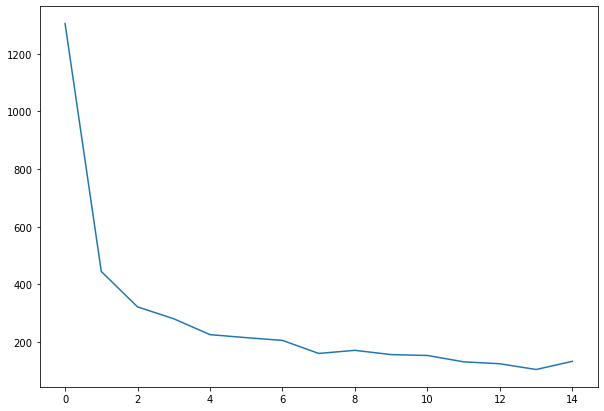

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 92.565
[2,  2000] loss: 111.478
[2,  3000] loss: 99.774
[2,  4000] loss: 85.693
[2,  5000] loss: 101.424
[2,  6000] loss: 82.315
[2,  7000] loss: 72.945
[2,  8000] loss: 77.227
[2,  9000] loss: 83.793
[2, 10000] loss: 75.676
[2, 11000] loss: 72.349
[2, 12000] loss: 80.906
[2, 13000] loss: 79.335
[2, 14000] loss: 81.281
[2, 15000] loss: 68.353
Обучение закончено


In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(2)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_1(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_1(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 98.987000 %
Accuracy of  1 : 98.754079 %
Accuracy of  2 : 98.371937 %
Accuracy of  3 : 96.770511 %
Accuracy of  4 : 98.065731 %
Accuracy of  5 : 98.874746 %
Accuracy of  6 : 99.121325 %
Accuracy of  7 : 97.956903 %
Accuracy of  8 : 96.342506 %
Accuracy of  9 : 98.571188 %
Accuracy : 98.180000 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_1(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.081633 %
Accuracy of  1 : 99.383260 %
Accuracy of  2 : 98.352713 %
Accuracy of  3 : 97.821782 %
Accuracy of  4 : 97.759674 %
Accuracy of  5 : 98.878924 %
Accuracy of  6 : 98.329854 %
Accuracy of  7 : 97.665370 %
Accuracy of  8 : 97.433265 %
Accuracy of  9 : 98.216056 %
Accuracy : 98.300000 %


Добавим еще один линейный слой и увеличим learning rate

In [18]:
class MNIST_model_2(nn.Module):
    def __init__(self):
        super(MNIST_model_2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 20, 120) 
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 20) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
net_2 = MNIST_model_2()

summary(net_2, (1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 24, 24]          416
├─MaxPool2d: 1-2                         [-1, 16, 12, 12]          --
├─Conv2d: 1-3                            [-1, 20, 8, 8]            8,020
├─MaxPool2d: 1-4                         [-1, 20, 4, 4]            --
├─Linear: 1-5                            [-1, 120]                 38,520
├─Linear: 1-6                            [-1, 60]                  7,260
├─Linear: 1-7                            [-1, 10]                  610
Total params: 54,826
Trainable params: 54,826
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.21
Estimated Total Size (MB): 0.29


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 24, 24]          416
├─MaxPool2d: 1-2                         [-1, 16, 12, 12]          --
├─Conv2d: 1-3                            [-1, 20, 8, 8]            8,020
├─MaxPool2d: 1-4                         [-1, 20, 4, 4]            --
├─Linear: 1-5                            [-1, 120]                 38,520
├─Linear: 1-6                            [-1, 60]                  7,260
├─Linear: 1-7                            [-1, 10]                  610
Total params: 54,826
Trainable params: 54,826
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.21
Estimated Total Size (MB): 0.29

In [20]:
from tqdm import tqdm_notebook
net_2 = MNIST_model_2().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 570.557
[1,  2000] loss: 184.396
[1,  3000] loss: 154.602
[1,  4000] loss: 125.051
[1,  5000] loss: 106.056
[1,  6000] loss: 99.573
[1,  7000] loss: 104.212
[1,  8000] loss: 87.298
[1,  9000] loss: 102.475
[1, 10000] loss: 81.808
[1, 11000] loss: 77.731
[1, 12000] loss: 71.126
[1, 13000] loss: 68.024
[1, 14000] loss: 81.809
[1, 15000] loss: 88.905


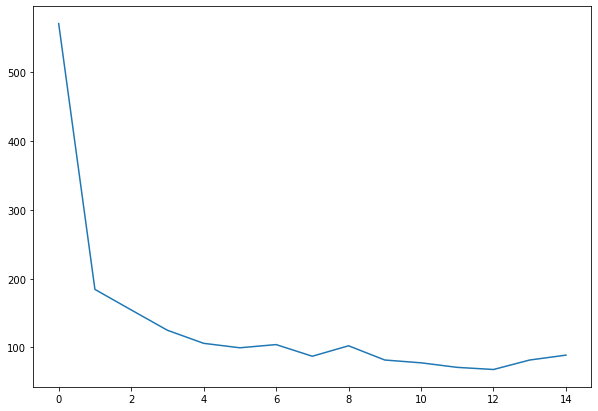

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 50.178
[2,  2000] loss: 70.313
[2,  3000] loss: 49.449
[2,  4000] loss: 53.523
[2,  5000] loss: 57.564
[2,  6000] loss: 55.309
[2,  7000] loss: 39.823
[2,  8000] loss: 58.160
[2,  9000] loss: 54.090
[2, 10000] loss: 62.793
[2, 11000] loss: 44.606
[2, 12000] loss: 54.860
[2, 13000] loss: 54.779
[2, 14000] loss: 63.268
[2, 15000] loss: 56.730
Обучение закончено


In [21]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(2)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_2(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_2(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 99.746750 %
Accuracy of  1 : 99.021062 %
Accuracy of  2 : 99.060087 %
Accuracy of  3 : 98.222150 %
Accuracy of  4 : 97.209860 %
Accuracy of  5 : 99.575724 %
Accuracy of  6 : 99.138222 %
Accuracy of  7 : 99.217877 %
Accuracy of  8 : 99.042899 %
Accuracy of  9 : 98.940998 %
Accuracy : 98.915000 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_2(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.591837 %
Accuracy of  1 : 99.559471 %
Accuracy of  2 : 99.224806 %
Accuracy of  3 : 98.415842 %
Accuracy of  4 : 97.657841 %
Accuracy of  5 : 99.215247 %
Accuracy of  6 : 98.225470 %
Accuracy of  7 : 99.416342 %
Accuracy of  8 : 99.383984 %
Accuracy of  9 : 97.621407 %
Accuracy : 98.840000 %


Слегка удалось повысить качество на обеих выборках 

Попробуем опять уменьшить learning rate и увеличим количество эпох

In [24]:
from tqdm import tqdm_notebook
net_2 = MNIST_model_2().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(net_2.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 1318.780
[1,  2000] loss: 401.508
[1,  3000] loss: 297.594
[1,  4000] loss: 256.577
[1,  5000] loss: 200.396
[1,  6000] loss: 193.334
[1,  7000] loss: 191.848
[1,  8000] loss: 146.883
[1,  9000] loss: 157.938
[1, 10000] loss: 149.010
[1, 11000] loss: 139.344
[1, 12000] loss: 126.588
[1, 13000] loss: 114.522
[1, 14000] loss: 105.401
[1, 15000] loss: 133.611


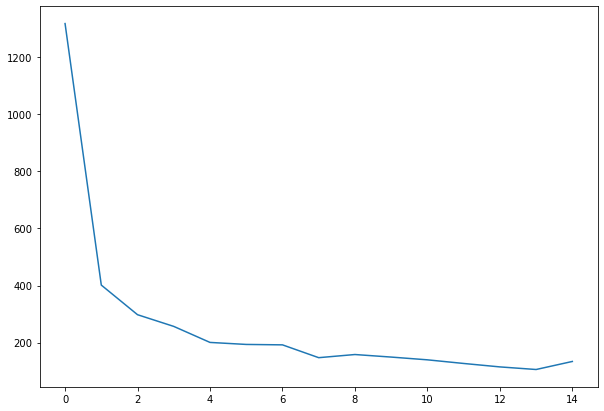

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 91.560
[2,  2000] loss: 106.563
[2,  3000] loss: 96.584
[2,  4000] loss: 91.578
[2,  5000] loss: 101.819
[2,  6000] loss: 81.522
[2,  7000] loss: 70.664
[2,  8000] loss: 84.126
[2,  9000] loss: 79.789
[2, 10000] loss: 77.112
[2, 11000] loss: 70.324
[2, 12000] loss: 86.983
[2, 13000] loss: 80.599
[2, 14000] loss: 78.843
[2, 15000] loss: 70.235


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  1000] loss: 62.232
[3,  2000] loss: 74.754
[3,  3000] loss: 73.296
[3,  4000] loss: 65.515
[3,  5000] loss: 62.270
[3,  6000] loss: 63.483
[3,  7000] loss: 56.661
[3,  8000] loss: 52.968
[3,  9000] loss: 56.113
[3, 10000] loss: 64.877
[3, 11000] loss: 54.813
[3, 12000] loss: 49.083
[3, 13000] loss: 69.731
[3, 14000] loss: 46.656
[3, 15000] loss: 63.122


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  1000] loss: 61.259
[4,  2000] loss: 46.803
[4,  3000] loss: 47.868
[4,  4000] loss: 57.607
[4,  5000] loss: 50.562
[4,  6000] loss: 44.108
[4,  7000] loss: 50.011
[4,  8000] loss: 46.929
[4,  9000] loss: 45.614
[4, 10000] loss: 52.093
[4, 11000] loss: 44.268
[4, 12000] loss: 43.523
[4, 13000] loss: 43.877
[4, 14000] loss: 45.077
[4, 15000] loss: 46.189
Обучение закончено


In [25]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(4)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_2(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [26]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_2(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 99.915583 %
Accuracy of  1 : 99.021062 %
Accuracy of  2 : 99.429339 %
Accuracy of  3 : 97.667591 %
Accuracy of  4 : 99.418008 %
Accuracy of  5 : 98.671832 %
Accuracy of  6 : 97.786414 %
Accuracy of  7 : 98.260176 %
Accuracy of  8 : 98.701077 %
Accuracy of  9 : 98.083712 %
Accuracy : 98.693333 %


In [27]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_2(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.795918 %
Accuracy of  1 : 99.383260 %
Accuracy of  2 : 99.515504 %
Accuracy of  3 : 98.514851 %
Accuracy of  4 : 99.185336 %
Accuracy of  5 : 98.318386 %
Accuracy of  6 : 96.242171 %
Accuracy of  7 : 97.762646 %
Accuracy of  8 : 98.767967 %
Accuracy of  9 : 97.918731 %
Accuracy : 98.560000 %


Судя по loss 2-х эпох вполне достаточно. Попробуем увеличить число свёрток.

In [28]:
class MNIST_model_3(nn.Module):
    def __init__(self):
        super(MNIST_model_3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 64, 150) 
        self.fc2 = nn.Linear(150, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 64) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
net_3 = MNIST_model_3()

summary(net_3, (1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            51,264
├─MaxPool2d: 1-4                         [-1, 64, 4, 4]            --
├─Linear: 1-5                            [-1, 150]                 153,750
├─Linear: 1-6                            [-1, 80]                  12,080
├─Linear: 1-7                            [-1, 10]                  810
Total params: 218,736
Trainable params: 218,736
Non-trainable params: 0
Total mult-adds (M): 3.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.83
Estimated Total Size (MB): 1.01


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            51,264
├─MaxPool2d: 1-4                         [-1, 64, 4, 4]            --
├─Linear: 1-5                            [-1, 150]                 153,750
├─Linear: 1-6                            [-1, 80]                  12,080
├─Linear: 1-7                            [-1, 10]                  810
Total params: 218,736
Trainable params: 218,736
Non-trainable params: 0
Total mult-adds (M): 3.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.83
Estimated Total Size (MB): 1.01

In [31]:
from tqdm import tqdm_notebook
net_3 = MNIST_model_3().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net_3.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 508.880
[1,  2000] loss: 156.754
[1,  3000] loss: 136.005
[1,  4000] loss: 107.346
[1,  5000] loss: 89.814
[1,  6000] loss: 90.310
[1,  7000] loss: 87.915
[1,  8000] loss: 82.874
[1,  9000] loss: 79.828
[1, 10000] loss: 77.703
[1, 11000] loss: 67.094
[1, 12000] loss: 62.892
[1, 13000] loss: 61.392
[1, 14000] loss: 66.277
[1, 15000] loss: 80.771


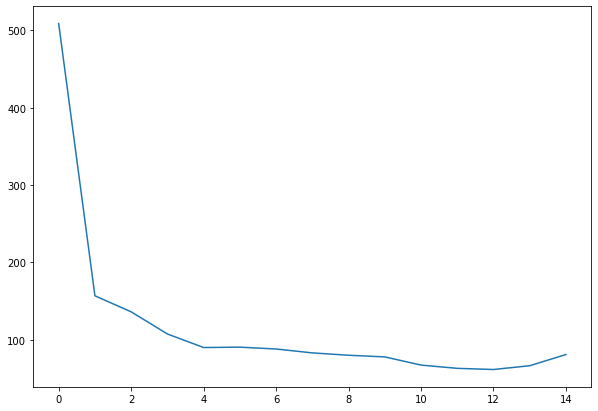

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 39.765
[2,  2000] loss: 60.113
[2,  3000] loss: 51.763
[2,  4000] loss: 56.912
[2,  5000] loss: 56.598
[2,  6000] loss: 48.095
[2,  7000] loss: 32.225
[2,  8000] loss: 49.171
[2,  9000] loss: 51.886
[2, 10000] loss: 48.145
[2, 11000] loss: 44.126
[2, 12000] loss: 64.882
[2, 13000] loss: 55.625
[2, 14000] loss: 62.484
[2, 15000] loss: 53.315
Обучение закончено


In [32]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(2)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_3(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_3(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 99.138950 %
Accuracy of  1 : 98.590923 %
Accuracy of  2 : 99.446123 %
Accuracy of  3 : 99.151851 %
Accuracy of  4 : 99.092776 %
Accuracy of  5 : 99.299022 %
Accuracy of  6 : 99.543765 %
Accuracy of  7 : 99.409417 %
Accuracy of  8 : 99.606905 %
Accuracy of  9 : 99.058665 %
Accuracy : 99.225000 %


In [34]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_3(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.183673 %
Accuracy of  1 : 98.766520 %
Accuracy of  2 : 99.031008 %
Accuracy of  3 : 99.009901 %
Accuracy of  4 : 99.083503 %
Accuracy of  5 : 98.991031 %
Accuracy of  6 : 98.851775 %
Accuracy of  7 : 99.221790 %
Accuracy of  8 : 99.383984 %
Accuracy of  9 : 98.216056 %
Accuracy : 98.970000 %


По итогу удалось повысить качество предсказания на тестовой выборке почти до 99%.
Попробуем заменить функцию активации relu на leaky_relu, чтобы избавиться от проблемы затухающих градиентов слева

In [35]:
class MNIST_model_4(nn.Module):
    def __init__(self):
        super(MNIST_model_4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 64, 150) 
        self.fc2 = nn.Linear(150, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 64) 
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
net_4 = MNIST_model_4()

summary(net_4, (1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            51,264
├─MaxPool2d: 1-4                         [-1, 64, 4, 4]            --
├─Linear: 1-5                            [-1, 150]                 153,750
├─Linear: 1-6                            [-1, 80]                  12,080
├─Linear: 1-7                            [-1, 10]                  810
Total params: 218,736
Trainable params: 218,736
Non-trainable params: 0
Total mult-adds (M): 3.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.83
Estimated Total Size (MB): 1.01


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 24, 24]          832
├─MaxPool2d: 1-2                         [-1, 32, 12, 12]          --
├─Conv2d: 1-3                            [-1, 64, 8, 8]            51,264
├─MaxPool2d: 1-4                         [-1, 64, 4, 4]            --
├─Linear: 1-5                            [-1, 150]                 153,750
├─Linear: 1-6                            [-1, 80]                  12,080
├─Linear: 1-7                            [-1, 10]                  810
Total params: 218,736
Trainable params: 218,736
Non-trainable params: 0
Total mult-adds (M): 3.90
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.83
Estimated Total Size (MB): 1.01

In [37]:
from tqdm import tqdm_notebook
net_4 = MNIST_model_4().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net_4.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 470.313
[1,  2000] loss: 151.666
[1,  3000] loss: 133.795
[1,  4000] loss: 103.107
[1,  5000] loss: 89.176
[1,  6000] loss: 87.288
[1,  7000] loss: 80.042
[1,  8000] loss: 78.336
[1,  9000] loss: 85.214
[1, 10000] loss: 82.390
[1, 11000] loss: 66.979
[1, 12000] loss: 67.807
[1, 13000] loss: 55.731
[1, 14000] loss: 73.195
[1, 15000] loss: 86.749


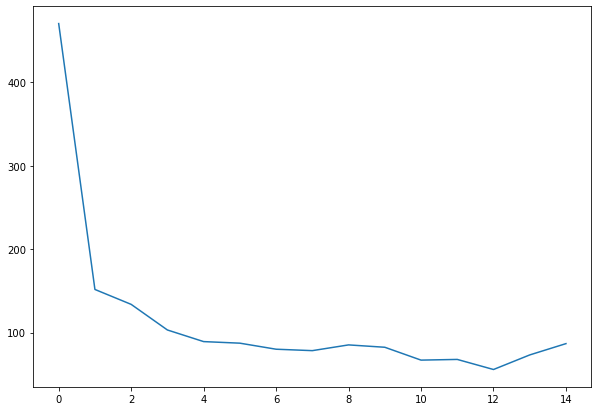

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 50.861
[2,  2000] loss: 63.654
[2,  3000] loss: 39.947
[2,  4000] loss: 49.385
[2,  5000] loss: 49.991
[2,  6000] loss: 56.727
[2,  7000] loss: 42.103
[2,  8000] loss: 52.712
[2,  9000] loss: 50.365
[2, 10000] loss: 56.979
[2, 11000] loss: 36.790
[2, 12000] loss: 58.381
[2, 13000] loss: 51.753
[2, 14000] loss: 71.406
[2, 15000] loss: 55.115
Обучение закончено


In [38]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(2)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_4(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_4(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 99.797400 %
Accuracy of  1 : 99.302877 %
Accuracy of  2 : 99.311850 %
Accuracy of  3 : 99.233404 %
Accuracy of  4 : 99.092776 %
Accuracy of  5 : 99.040767 %
Accuracy of  6 : 99.814126 %
Accuracy of  7 : 98.643256 %
Accuracy of  8 : 99.111263 %
Accuracy of  9 : 99.260380 %
Accuracy : 99.260000 %


In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_4(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.693878 %
Accuracy of  1 : 98.678414 %
Accuracy of  2 : 99.031008 %
Accuracy of  3 : 99.009901 %
Accuracy of  4 : 99.083503 %
Accuracy of  5 : 98.654709 %
Accuracy of  6 : 99.373695 %
Accuracy of  7 : 98.832685 %
Accuracy of  8 : 98.973306 %
Accuracy of  9 : 98.612488 %
Accuracy : 98.990000 %


Качество на тестовой выборке еще больше приблизилось к отметке 99%

Попробуем улучшить качество модели добавлением сверток меньшего размера и нормализации

In [36]:
class MNIST_model_5(nn.Module):
    def __init__(self):
        super(MNIST_model_5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2)
        self.fc1 = nn.Linear(5 * 5 * 64, 150) 
        self.fc2 = nn.Linear(150, 10)
        self.bn = nn.BatchNorm2d(64)

    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(F.leaky_relu(self.bn(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn(self.conv3(x))))
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 64) 
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [37]:
net_5 = MNIST_model_5()

summary(net_5, (1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,664
├─Conv2d: 1-2                            [-1, 64, 22, 22]          36,928
├─BatchNorm2d: 1-3                       [-1, 64, 22, 22]          128
├─MaxPool2d: 1-4                         [-1, 64, 11, 11]          --
├─Conv2d: 1-5                            [-1, 64, 10, 10]          16,448
├─BatchNorm2d: 1-6                       [-1, 64, 10, 10]          (recursive)
├─MaxPool2d: 1-7                         [-1, 64, 5, 5]            --
├─Linear: 1-8                            [-1, 150]                 240,150
├─Linear: 1-9                            [-1, 10]                  1,510
Total params: 296,828
Trainable params: 296,828
Non-trainable params: 0
Total mult-adds (M): 20.64
Input size (MB): 0.00
Forward/backward pass size (MB): 0.80
Params size (MB): 1.13
Estimated Total Size (MB): 1.94


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 24, 24]          1,664
├─Conv2d: 1-2                            [-1, 64, 22, 22]          36,928
├─BatchNorm2d: 1-3                       [-1, 64, 22, 22]          128
├─MaxPool2d: 1-4                         [-1, 64, 11, 11]          --
├─Conv2d: 1-5                            [-1, 64, 10, 10]          16,448
├─BatchNorm2d: 1-6                       [-1, 64, 10, 10]          (recursive)
├─MaxPool2d: 1-7                         [-1, 64, 5, 5]            --
├─Linear: 1-8                            [-1, 150]                 240,150
├─Linear: 1-9                            [-1, 10]                  1,510
Total params: 296,828
Trainable params: 296,828
Non-trainable params: 0
Total mult-adds (M): 20.64
Input size (MB): 0.00
Forward/backward pass size (MB): 0.80
Params size (MB): 1.13
Estimated Total Size (MB): 1.94

In [38]:
from tqdm import tqdm_notebook
net_5 = MNIST_model_5().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net_5.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 340.313
[1,  2000] loss: 158.956
[1,  3000] loss: 142.486
[1,  4000] loss: 110.329
[1,  5000] loss: 94.554
[1,  6000] loss: 91.073
[1,  7000] loss: 98.959
[1,  8000] loss: 80.668
[1,  9000] loss: 80.630
[1, 10000] loss: 68.776
[1, 11000] loss: 74.708
[1, 12000] loss: 62.697
[1, 13000] loss: 50.835
[1, 14000] loss: 55.463
[1, 15000] loss: 82.387


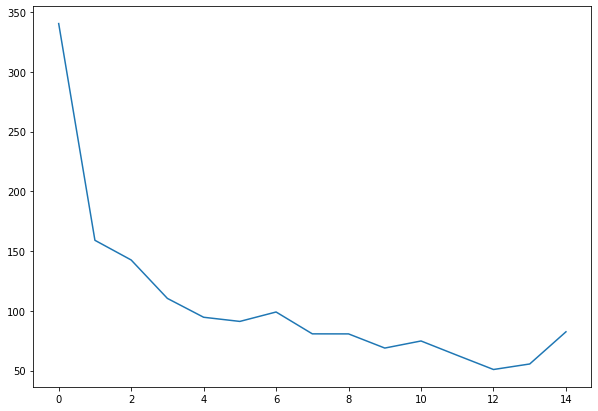

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 39.253
[2,  2000] loss: 59.666
[2,  3000] loss: 41.604
[2,  4000] loss: 53.750
[2,  5000] loss: 49.908
[2,  6000] loss: 43.635
[2,  7000] loss: 23.141
[2,  8000] loss: 45.984
[2,  9000] loss: 49.638
[2, 10000] loss: 54.140
[2, 11000] loss: 35.708
[2, 12000] loss: 51.990
[2, 13000] loss: 47.814
[2, 14000] loss: 43.217
[2, 15000] loss: 48.321


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  1000] loss: 23.899
[3,  2000] loss: 41.098
[3,  3000] loss: 44.051
[3,  4000] loss: 29.275
[3,  5000] loss: 30.345
[3,  6000] loss: 36.637
[3,  7000] loss: 38.098
[3,  8000] loss: 34.457
[3,  9000] loss: 35.912
[3, 10000] loss: 34.930
[3, 11000] loss: 34.132
[3, 12000] loss: 28.991
[3, 13000] loss: 41.457
[3, 14000] loss: 27.297
[3, 15000] loss: 36.765
Обучение закончено


In [39]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(3)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_5(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [40]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_5(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 99.848050 %
Accuracy of  1 : 99.599525 %
Accuracy of  2 : 99.563612 %
Accuracy of  3 : 99.233404 %
Accuracy of  4 : 99.486477 %
Accuracy of  5 : 99.391256 %
Accuracy of  6 : 99.526867 %
Accuracy of  7 : 99.584996 %
Accuracy of  8 : 99.538540 %
Accuracy of  9 : 99.176332 %
Accuracy : 99.496667 %


In [41]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_5(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.795918 %
Accuracy of  1 : 99.735683 %
Accuracy of  2 : 99.806202 %
Accuracy of  3 : 99.306931 %
Accuracy of  4 : 99.389002 %
Accuracy of  5 : 98.991031 %
Accuracy of  6 : 98.538622 %
Accuracy of  7 : 99.124514 %
Accuracy of  8 : 99.486653 %
Accuracy of  9 : 98.909812 %
Accuracy : 99.320000 %


Качество на тестовой выборке повысилось до 99.32%

 Альтернативное решение, дающее качество на тестовой выборке ~99%, однако число параметров меньше в 3 раза, что алгоритмически более привлекательно, по сравнению, например, с моделью №4 (используется свертка 1*1)

In [53]:
class MNIST_model_6(nn.Module):
    def __init__(self):
        super(MNIST_model_6, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1)
        self.fc1 = nn.Linear(5 * 5 * 16, 150) 
        self.fc2 = nn.Linear(150, 10)
        self.bn_1 = nn.BatchNorm2d(16)
        self.bn_2 = nn.BatchNorm2d(32)

    def forward(self, x):
        
        x = self.pool(F.leaky_relu(self.bn_1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn_2(self.conv2(x))))
        x = F.leaky_relu(self.conv3(x))
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16) 
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [54]:
net_6 = MNIST_model_6()

summary(net_6, (1,28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 24, 24]          416
├─BatchNorm2d: 1-2                       [-1, 16, 24, 24]          32
├─MaxPool2d: 1-3                         [-1, 16, 12, 12]          --
├─Conv2d: 1-4                            [-1, 32, 10, 10]          4,640
├─BatchNorm2d: 1-5                       [-1, 32, 10, 10]          64
├─MaxPool2d: 1-6                         [-1, 32, 5, 5]            --
├─Conv2d: 1-7                            [-1, 16, 5, 5]            528
├─Linear: 1-8                            [-1, 150]                 60,150
├─Linear: 1-9                            [-1, 10]                  1,510
Total params: 67,340
Trainable params: 67,340
Non-trainable params: 0
Total mult-adds (M): 0.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.26
Estimated Total Size (MB): 0.45


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 16, 24, 24]          416
├─BatchNorm2d: 1-2                       [-1, 16, 24, 24]          32
├─MaxPool2d: 1-3                         [-1, 16, 12, 12]          --
├─Conv2d: 1-4                            [-1, 32, 10, 10]          4,640
├─BatchNorm2d: 1-5                       [-1, 32, 10, 10]          64
├─MaxPool2d: 1-6                         [-1, 32, 5, 5]            --
├─Conv2d: 1-7                            [-1, 16, 5, 5]            528
├─Linear: 1-8                            [-1, 150]                 60,150
├─Linear: 1-9                            [-1, 10]                  1,510
Total params: 67,340
Trainable params: 67,340
Non-trainable params: 0
Total mult-adds (M): 0.77
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.26
Estimated Total Size (MB): 0.45

In [55]:
from tqdm import tqdm_notebook
net_6 = MNIST_model_6().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(net_6.parameters(), lr=learning_rate)
losses = []

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  1000] loss: 375.987
[1,  2000] loss: 152.567
[1,  3000] loss: 133.787
[1,  4000] loss: 101.846
[1,  5000] loss: 91.182
[1,  6000] loss: 86.667
[1,  7000] loss: 94.268
[1,  8000] loss: 78.212
[1,  9000] loss: 84.686
[1, 10000] loss: 75.065
[1, 11000] loss: 76.241
[1, 12000] loss: 70.297
[1, 13000] loss: 66.970
[1, 14000] loss: 52.887
[1, 15000] loss: 90.953


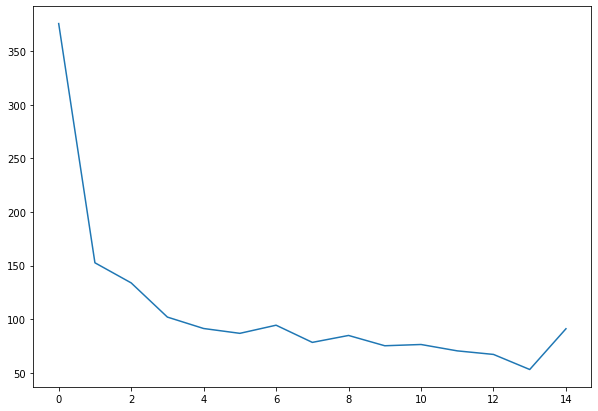

  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  1000] loss: 47.286
[2,  2000] loss: 60.764
[2,  3000] loss: 52.510
[2,  4000] loss: 57.747
[2,  5000] loss: 59.675
[2,  6000] loss: 50.773
[2,  7000] loss: 31.712
[2,  8000] loss: 42.070
[2,  9000] loss: 57.783
[2, 10000] loss: 61.239
[2, 11000] loss: 43.637
[2, 12000] loss: 59.801
[2, 13000] loss: 57.700
[2, 14000] loss: 56.764
[2, 15000] loss: 54.141


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  1000] loss: 29.146
[3,  2000] loss: 48.939
[3,  3000] loss: 43.934
[3,  4000] loss: 32.056
[3,  5000] loss: 42.714
[3,  6000] loss: 48.184
[3,  7000] loss: 38.371
[3,  8000] loss: 43.507
[3,  9000] loss: 41.429
[3, 10000] loss: 40.229
[3, 11000] loss: 41.734
[3, 12000] loss: 37.078
[3, 13000] loss: 33.661
[3, 14000] loss: 26.858
[3, 15000] loss: 44.420
Обучение закончено


In [56]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
torch.manual_seed(42)
for epoch in tqdm_notebook(range(3)):
    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        X_batch, y_batch = batch
        optimizer.zero_grad()
        y_pred = net_6(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0

    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

In [57]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        y_pred = net_6(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 60000))

Accuracy of  0 : 99.611683 %
Accuracy of  1 : 99.288045 %
Accuracy of  2 : 99.630749 %
Accuracy of  3 : 99.314957 %
Accuracy of  4 : 99.212598 %
Accuracy of  5 : 99.169895 %
Accuracy of  6 : 99.628253 %
Accuracy of  7 : 99.010375 %
Accuracy of  8 : 99.094172 %
Accuracy of  9 : 98.907379 %
Accuracy : 99.286667 %


In [58]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_6(images.to(device))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
class_correct_all = 0

for i in range(10):
    print('Accuracy of %2s : %2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    class_correct_all += class_correct[i]
print('Accuracy : %2f %%' % (100 * class_correct_all/ 10000))

Accuracy of  0 : 99.795918 %
Accuracy of  1 : 99.559471 %
Accuracy of  2 : 99.515504 %
Accuracy of  3 : 98.811881 %
Accuracy of  4 : 99.185336 %
Accuracy of  5 : 98.766816 %
Accuracy of  6 : 98.538622 %
Accuracy of  7 : 98.346304 %
Accuracy of  8 : 98.973306 %
Accuracy of  9 : 98.216056 %
Accuracy : 98.980000 %
